In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cellphone_3w.csv to cellphone_3w.csv


In [3]:
raw_reviews = pd.read_csv('cellphone_3w.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(30024, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30024 entries, 0 to 30023
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  30024 non-null  object 
 1   Brand Name    23022 non-null  object 
 2   Price         28410 non-null  float64
 3   Rating        30024 non-null  int64  
 4   Reviews       30011 non-null  object 
 5   Review Votes  29100 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.4+ MB
None


In [4]:
raw_reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [5]:
process_reviews=raw_reviews.copy()

In [6]:
process_reviews.isnull().sum()

Product Name       0
Brand Name      7002
Price           1614
Rating             0
Reviews           13
Review Votes     924
dtype: int64

In [7]:
process_reviews=process_reviews.dropna()

In [8]:
process_reviews.isnull().sum()

Product Name    0
Brand Name      0
Price           0
Rating          0
Reviews         0
Review Votes    0
dtype: int64

In [9]:
process_reviews['Rating'].value_counts()

5    11780
1     4804
4     2837
3     1565
2     1378
Name: Rating, dtype: int64

In [10]:
def f(row):
    
    if row['Rating'] == 3:
        val = 'Neutral'
    elif row['Rating'] == 1 or row['Rating'] == 2:
        val = 'Negative'
    elif row['Rating'] == 4 or row['Rating'] == 5:
        val = 'Positive'
    else:
        val = -1
    return val

In [11]:
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,Positive


In [12]:
process_reviews['sentiment'].value_counts()


Positive    14617
Negative     6182
Neutral      1565
Name: sentiment, dtype: int64

In [13]:
process_reviews['Review Votes'].value_counts()

0.0      15927
1.0       3144
2.0       1281
3.0        523
4.0        329
         ...  
141.0        1
159.0        1
79.0         1
56.0         1
52.0         1
Name: Review Votes, Length: 101, dtype: int64

In [14]:

#Creating a copy 
clean_reviews=process_reviews.copy()

In [15]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
process_reviews['Reviews']=process_reviews['Reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,i feel so lucky to have found this used phone ...,1.0,Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,nice phone nice up grade from my pantach revue...,0.0,Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,very pleased,0.0,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,it works good but it goes slow sometimes but i...,0.0,Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,great phone to replace my lost phone the only ...,0.0,Positive


In [17]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [18]:
process_reviews['Reviews'] = process_reviews['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,feel lucky found used phone us not used hard p...,1.0,Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,pleased,0.0,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,works good but goes slow sometimes but good ph...,0.0,Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,Positive


In [19]:
process_reviews['polarity'] = process_reviews['Reviews'].map(lambda text: TextBlob(text).sentiment.polarity)

In [20]:
process_reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,polarity
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,feel lucky found used phone us not used hard p...,1.0,Positive,0.157381
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,Positive,0.437037
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,pleased,0.0,Positive,0.500000
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,works good but goes slow sometimes but good ph...,0.0,Positive,0.400000
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,Positive,0.800000


In [21]:
process_reviews['sentiment'].value_counts()

Positive    14617
Negative     6182
Neutral      1565
Name: sentiment, dtype: int64

In [22]:
pd.DataFrame(process_reviews.groupby('sentiment')['Review Votes'].mean())

,Review Votes
sentiment,
Negative,2.887739
Neutral,1.060064
Positive,0.925566


In [23]:
# Encode labels in column 'sentiment'. 
label_encoder = preprocessing.LabelEncoder() 
  
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 0, 1])

In [24]:
process_reviews['sentiment'].value_counts()

2    14617
0     6182
1     1565
Name: sentiment, dtype: int64

In [25]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['Reviews']].reset_index(drop=True)
review_features.head()

,Reviews
0,feel lucky found used phone us not used hard p...
1,nice phone nice grade pantach revue clean set ...
2,pleased
3,works good but goes slow sometimes but good ph...
4,great phone replace lost phone thing volume bu...


In [26]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['Reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  

In [27]:
corpus[5]

'alreadi phone problem know state use but dang not state not charg wish would read comment would not purchas item crack side damag good if tri charg anoth way not work request money back will get money backsign unhappi custom'

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['Reviews'])

In [29]:
X.shape

(22364, 5000)

In [30]:
y=process_reviews['sentiment']

In [31]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 14617, 0: 6182, 1: 1565})
Resampled dataset shape Counter({2: 14617, 0: 14617, 1: 14617})


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [33]:

logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.839164726749584
Decision Tree Test Accuracy: 0.8118031592592623
KNN Test Accuracy: 0.7193316502503432
Naive Bayes Test Accuracy: 0.7936487941059575


In [34]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.8860713308400985


In [35]:
logreg = LogisticRegression(C=10000,random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


In [36]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[3200   77  380]
 [  45 3163  496]
 [  79  172 3351]]


In [37]:
def plot_cm(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

Confusion matrix, without normalization


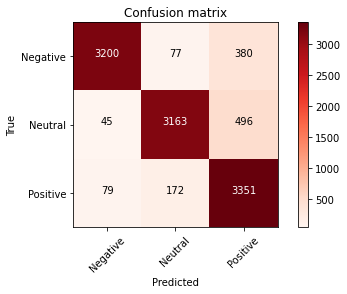

In [38]:
plot_cm(cm, classes=['Negative','Neutral','Positive'])

In [39]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3657
           1       0.93      0.85      0.89      3704
           2       0.79      0.93      0.86      3602

    accuracy                           0.89     10963
   macro avg       0.89      0.89      0.89     10963
weighted avg       0.89      0.89      0.89     10963

